In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import joblib


In [5]:
# Load training and test data
train_df = pd.read_csv('../data/train_df.csv')
test_df = pd.read_csv('../data/test_df.csv')
sample_submission = pd.read_csv('../data/sample_submission.csv')

# Preview data
print("Training Data:")
display(train_df.head())

print("Test Data:")
display(test_df.head())

print("Sample Submission:")
display(sample_submission.head())


Training Data:


,age,gender,primary_diagnosis,num_procedures,days_in_hospital,comorbidity_score,discharge_to,readmitted
0,69,Male,Heart Disease,1,2,1,Home Health Care,0
1,32,Female,COPD,2,13,2,Rehabilitation Facility,0
2,89,Male,Diabetes,1,7,1,Home,0
3,78,Male,COPD,9,2,2,Skilled Nursing Facility,0
4,38,Male,Diabetes,6,4,4,Rehabilitation Facility,0


Test Data:


,age,gender,primary_diagnosis,num_procedures,days_in_hospital,comorbidity_score,discharge_to
0,52,Male,Heart Disease,3,9,3,Home
1,47,Female,Diabetes,2,4,0,Skilled Nursing Facility
2,72,Female,Heart Disease,7,12,4,Home
3,18,Female,COPD,5,14,3,Home
4,32,Male,Heart Disease,9,2,4,Rehabilitation Facility


Sample Submission:


,Patient_ID,readmitted
0,1,1
1,2,0
2,3,1
3,4,1
4,5,1


Train shape: (5000, 8)
Test shape: (2000, 7)


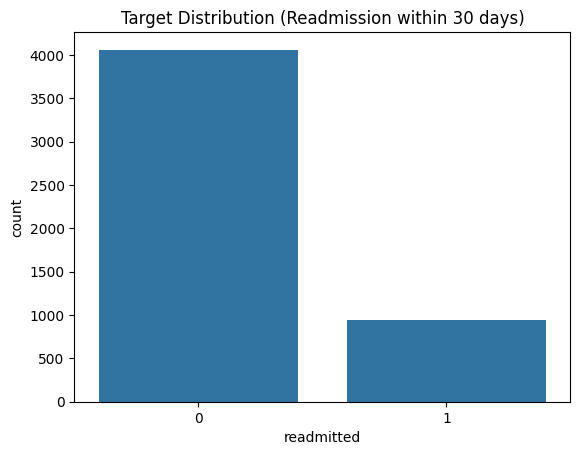

age                  0
gender               0
primary_diagnosis    0
num_procedures       0
days_in_hospital     0
comorbidity_score    0
discharge_to         0
readmitted           0
dtype: int64
age                  0
gender               0
primary_diagnosis    0
num_procedures       0
days_in_hospital     0
comorbidity_score    0
discharge_to         0
dtype: int64


In [6]:
# Check shape of datasets
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

# Check target distribution
sns.countplot(x='readmitted', data=train_df)
plt.title("Target Distribution (Readmission within 30 days)")
plt.show()

# Check for missing values
print(train_df.isnull().sum())
print(test_df.isnull().sum())


In [7]:
# Separate features (X) and target (y)
X = train_df.drop('readmitted', axis=1)
y = train_df['readmitted']

# Fill missing categorical values with mode and numerical with median
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = X[col].fillna(X[col].mode()[0])
        test_df[col] = test_df[col].fillna(test_df[col].mode()[0])
    else:
        X[col] = X[col].fillna(X[col].median())
        test_df[col] = test_df[col].fillna(test_df[col].median())

# Encode categorical variables
cat_cols = X.select_dtypes(include=['object']).columns

X = pd.get_dummies(X, columns=cat_cols, drop_first=True)
test_df = pd.get_dummies(test_df, columns=cat_cols, drop_first=True)

# Align train and test columns
X, test_df = X.align(test_df, join='left', axis=1, fill_value=0)


In [8]:
print(" Sanity Check:")

# Check shapes
print(f"X (train features): {X.shape}")
print(f"y (target): {y.shape}")
print(f"test_df (test features): {test_df.shape}")

# Quick look at column alignment
print("\nFirst 5 columns in X:", X.columns[:5].tolist())
print("First 5 columns in test_df:", test_df.columns[:5].tolist())

# Check if column sets match
print("\nDo X and test_df have the same columns? ", set(X.columns) == set(test_df.columns))


 Sanity Check:
X (train features): (5000, 12)
y (target): (5000,)
test_df (test features): (2000, 12)

First 5 columns in X: ['age', 'num_procedures', 'days_in_hospital', 'comorbidity_score', 'gender_Male']
First 5 columns in test_df: ['age', 'num_procedures', 'days_in_hospital', 'comorbidity_score', 'gender_Male']

Do X and test_df have the same columns?  True


In [9]:
from sklearn.model_selection import train_test_split

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)


Train set: (4000, 12) (4000,)
Validation set: (1000, 12) (1000,)


In [11]:
# Handle imbalance with SMOTE + Random Forest Hyperparameter Tuning

from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score
import joblib

# Apply SMOTE on training set (only training, not validation)
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

print("Before SMOTE:", X_train.shape, y_train.value_counts().to_dict())
print("After SMOTE:", X_res.shape, y_res.value_counts().to_dict())

# Define base RF model
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Define hyperparameter grid
param_dist = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [5, 10, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "bootstrap": [True, False]
}

# RandomizedSearchCV for faster tuning
rf_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,
    scoring="roc_auc",
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=2
)

# Fit tuned model
rf_search.fit(X_res, y_res)

# Best model
best_rf = rf_search.best_estimator_
print("\nBest Parameters:", rf_search.best_params_)

# Evaluate on validation set
y_val_pred = best_rf.predict(X_val)
y_val_proba = best_rf.predict_proba(X_val)[:, 1]

print("\nValidation Classification Report:\n", classification_report(y_val, y_val_pred))
print("Validation ROC-AUC:", roc_auc_score(y_val, y_val_proba))

# Save tuned model for later use in Dash app
joblib.dump(best_rf, "../models/rf_readmission_tuned.pkl")
print("\n Tuned model saved to ../models/rf_readmission_tuned.pkl")


Before SMOTE: (4000, 12) {0: 3248, 1: 752}
After SMOTE: (6496, 12) {0: 3248, 1: 3248}
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best Parameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20, 'bootstrap': True}

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.84      0.83       812
           1       0.17      0.14      0.16       188

    accuracy                           0.71      1000
   macro avg       0.49      0.49      0.49      1000
weighted avg       0.69      0.71      0.70      1000

Validation ROC-AUC: 0.5132061628760088

 Tuned model saved to ../models/rf_readmission_tuned.pkl


### Why Random Forest Was Not Enough

Above we trained a Random Forest classifier with SMOTE to handle class imbalance.  
While the model achieved ~71% accuracy, it struggled with **recall** for the minority class (patients likely to be readmitted).  
Specifically:
- The model correctly identified "not readmitted" patients but failed to catch enough "readmitted" cases.
- The ROC-AUC score was ~0.51, which is close to random guessing.
- This suggests Random Forest, even with SMOTE and tuning, was biased toward the majority class.

Since our business goal is **not to miss high-risk patients**, we need a model that better handles imbalanced data.  

### Why Try XGBoost

XGBoost (Extreme Gradient Boosting) often outperforms Random Forest on **tabular, imbalanced datasets**.  
Key reasons:
- It uses **gradient boosting**, which builds stronger learners by focusing on difficult-to-classify cases.
- It supports a parameter `scale_pos_weight` that directly addresses class imbalance.
- Typically, it achieves higher recall and better generalization on small-to-medium healthcare datasets.

Thus, we will train and tune an XGBoost model to improve recall for predicting patient readmissions.


In [12]:
# XGBoost with SMOTE + Hyperparameter Tuning

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score

# Apply SMOTE again on training set
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

print("SMOTE Balanced Classes:", y_res.value_counts().to_dict())

# Define base XGBoost model
xgb_clf = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

# Define hyperparameter search space
param_dist_xgb = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [3, 5, 7, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "scale_pos_weight": [1, 2, 5]  # helps with imbalance
}

# Randomized search
xgb_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist_xgb,
    n_iter=20,
    scoring="recall",   # Focus on recall for readmitted patients
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=2
)

# Fit tuned model
xgb_search.fit(X_res, y_res)

# Best model
best_xgb = xgb_search.best_estimator_
print("\nBest Parameters for XGBoost:", xgb_search.best_params_)

# Evaluate on validation set
y_val_pred = best_xgb.predict(X_val)
y_val_proba = best_xgb.predict_proba(X_val)[:, 1]

print("\nValidation Classification Report:\n", classification_report(y_val, y_val_pred))
print("Validation ROC-AUC:", roc_auc_score(y_val, y_val_proba))

# Save tuned XGBoost model
joblib.dump(best_xgb, "../models/xgb_readmission_tuned.pkl")
print("\n Tuned XGBoost model saved to ../models/xgb_readmission_tuned.pkl")


SMOTE Balanced Classes: {0: 3248, 1: 3248}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


c:\siddharth\Projects\Patient_portal_ML\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:25:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Best Parameters for XGBoost: {'subsample': 0.8, 'scale_pos_weight': 5, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.8}

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.06      0.11       812
           1       0.19      0.93      0.31       188

    accuracy                           0.23      1000
   macro avg       0.49      0.50      0.21      1000
weighted avg       0.68      0.23      0.15      1000

Validation ROC-AUC: 0.5043168955036159

 Tuned XGBoost model saved to ../models/xgb_readmission_tuned.pkl


In [14]:
# Calibrate the tuned Random Forest
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, classification_report

# Wrap the tuned RF in a calibration layer
cal_rf = CalibratedClassifierCV(estimator=best_rf, method="isotonic", cv=5)
cal_rf.fit(X_train, y_train)

# Evaluate calibrated model
y_val_proba_cal = cal_rf.predict_proba(X_val)[:, 1]
y_val_pred_cal = (y_val_proba_cal >= 0.5).astype(int)

print("Calibrated ROC-AUC:", roc_auc_score(y_val, y_val_proba_cal))
print("Calibrated Classification Report:\n", classification_report(y_val, y_val_pred_cal))

# Save calibrated model
import joblib
joblib.dump(cal_rf, "../models/rf_readmission_tuned_calibrated.pkl")
print(" Calibrated RF model saved to ../models/rf_readmission_tuned_calibrated.pkl")


Calibrated ROC-AUC: 0.5154694214442931
Calibrated Classification Report:
               precision    recall  f1-score   support

           0       0.81      1.00      0.90       812
           1       0.00      0.00      0.00       188

    accuracy                           0.81      1000
   macro avg       0.41      0.50      0.45      1000
weighted avg       0.66      0.81      0.73      1000



c:\siddharth\Projects\Patient_portal_ML\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\siddharth\Projects\Patient_portal_ML\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\siddharth\Projects\Patient_portal_ML\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

 Calibrated RF model saved to ../models/rf_readmission_tuned_calibrated.pkl


In [16]:
# Random Forest with Class Weights (Improved)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
import joblib

# Train RF with class_weight balanced
rf_balanced = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    class_weight="balanced",   # key difference
    random_state=42,
    n_jobs=-1
)

rf_balanced.fit(X_train, y_train)

# Predictions
y_val_pred_bal = rf_balanced.predict(X_val)
y_val_proba_bal = rf_balanced.predict_proba(X_val)[:, 1]

# Print evaluation
print("Class-Weighted RF Classification Report:\n", classification_report(y_val, y_val_pred_bal))
print("ROC-AUC:", roc_auc_score(y_val, y_val_proba_bal))

# Save model
joblib.dump(rf_balanced, "../models/rf_readmission_classweight.pkl")
print(" Class-weighted RF model saved to ../models/rf_readmission_classweight.pkl")

# Save metrics in a dict (for Step 11)
results_classweight = {
    "Model": "RF + Class Weights",
    "Accuracy": accuracy_score(y_val, y_val_pred_bal),
    "Precision": precision_score(y_val, y_val_pred_bal, zero_division=0),
    "Recall": recall_score(y_val, y_val_pred_bal, zero_division=0),
    "F1 Score": f1_score(y_val, y_val_pred_bal, zero_division=0),
    "ROC-AUC": roc_auc_score(y_val, y_val_proba_bal)
}


Class-Weighted RF Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.99      0.89       812
           1       0.00      0.00      0.00       188

    accuracy                           0.80      1000
   macro avg       0.41      0.50      0.45      1000
weighted avg       0.66      0.80      0.72      1000

ROC-AUC: 0.524466774971177
 Class-weighted RF model saved to ../models/rf_readmission_classweight.pkl


In [17]:
# Compare All Models Side by Side
import pandas as pd

results = []

# 1. RF + SMOTE (tuned)
results.append({
    "Model": "RF + SMOTE (tuned)",
    "Accuracy": accuracy_score(y_val, best_rf.predict(X_val)),
    "Precision": precision_score(y_val, best_rf.predict(X_val), zero_division=0),
    "Recall": recall_score(y_val, best_rf.predict(X_val), zero_division=0),
    "F1 Score": f1_score(y_val, best_rf.predict(X_val), zero_division=0),
    "ROC-AUC": roc_auc_score(y_val, best_rf.predict_proba(X_val)[:, 1])
})

# 2. RF + Calibration
results.append({
    "Model": "RF + Calibration",
    "Accuracy": accuracy_score(y_val, cal_rf.predict(X_val)),
    "Precision": precision_score(y_val, cal_rf.predict(X_val), zero_division=0),
    "Recall": recall_score(y_val, cal_rf.predict(X_val), zero_division=0),
    "F1 Score": f1_score(y_val, cal_rf.predict(X_val), zero_division=0),
    "ROC-AUC": roc_auc_score(y_val, cal_rf.predict_proba(X_val)[:, 1])
})

# 3. RF + Class Weights (from Step 10)
results.append(results_classweight)

# Create DataFrame
df_results = pd.DataFrame(results)
print("Model Comparison:\n")
display(df_results)


Model Comparison:



,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC
0,RF + SMOTE (tuned),0.711,0.174194,0.143617,0.157434,0.513206
1,RF + Calibration,0.812,0.000000,0.000000,0.000000,0.515469
2,RF + Class Weights,0.804,0.000000,0.000000,0.000000,0.524467
